# Logistic Regression

Chapter 16 of _Data Science from Scratch_

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
from typing import List, Dict, Iterable, Tuple, Callable
import math
import os
import random
import sys
import numpy as np
import pandas as pd
import tqdm
from functools import partial, reduce

In [4]:
book_dir = '/Users/CBare/Documents/projects/data-science-from-scratch'
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8,16])

In [5]:
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
    
    
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)


def step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                          negate_all(gradient_fn),
                          x,
                          y,
                          theta_0,
                          alpha_0 = 0.01)
def	in_random_order(data):
				"""generator	that	returns	the	elements	of	data	in	random	order"""
				indexes	=	[i	for	i,	_	in	enumerate(data)]		#	create	a	list	of	indexes
				random.shuffle(indexes)																				#	shuffle	them
				for	i	in	indexes:																										#	return	the	data	in	that	order
								yield	data[i]
                        
def minimize_stochastic2(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
        # stop if we're "converging"
        next_value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        if abs(value - next_value) < tolerance:
            break

    return min_theta,iterations_with_no_improvement

def maximize_stochastic2(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    return minimize_stochastic2(negate(target_fn),
                          negate_all(gradient_fn),
                          x,
                          y,
                          theta_0,
                          alpha_0 = 0.01,tolerance=0.000001)                       
                        

In [6]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f
                                                                
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)
    values = []
    
    # set theta to initial value
    # safe version of target_fn
    # value we're minimizing
    while True:
        values.append(value)
        gradient = gradient_fn(theta)
        next_thetas = [np.array(step(theta, gradient, -step_size))
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            values.append(next_value)
            break
        else:
            theta, value = next_theta, next_value

    return theta, values
    
    
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

import re, math, random # regexes, math functions, random numbers
import matplotlib.pyplot as plt # pyplot
from collections import defaultdict, Counter
from functools import partial, reduce

#
# functions for working with vectors
#

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

#
# functions for working with matrices
#

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_row(A, i):
    return A[i]

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

def is_diagonal(i, j):
    """1's on the 'diagonal', 0's everywhere else"""
    return 1 if i == j else 0

identity_matrix = make_matrix(5, 5, is_diagonal)

#          user 0  1  2  3  4  5  6  7  8  9
#
friendships = [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0], # user 0
               [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], # user 1
               [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], # user 2
               [0, 1, 1, 0, 1, 0, 0, 0, 0, 0], # user 3
               [0, 0, 0, 1, 0, 1, 0, 0, 0, 0], # user 4
               [0, 0, 0, 0, 1, 0, 1, 1, 0, 0], # user 5
               [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], # user 6
               [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], # user 7
               [0, 0, 0, 0, 0, 0, 1, 1, 0, 1], # user 8
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]] # user 9

#####
# DELETE DOWN
#


def matrix_add(A, B):
    if shape(A) != shape(B):
        raise ArithmeticError("cannot add matrices with different shapes")

    num_rows, num_cols = shape(A)
    def entry_fn(i, j): return A[i][j] + B[i][j]

    return make_matrix(num_rows, num_cols, entry_fn)


def make_graph_dot_product_as_vector_projection(plt):

    v = [2, 1]
    w = [math.sqrt(.25), math.sqrt(.75)]
    c = dot(v, w)
    vonw = scalar_multiply(c, w)
    o = [0,0]

    plt.arrow(0, 0, v[0], v[1],
              width=0.002, head_width=.1, length_includes_head=True)
    plt.annotate("v", v, xytext=[v[0] + 0.1, v[1]])
    plt.arrow(0 ,0, w[0], w[1],
              width=0.002, head_width=.1, length_includes_head=True)
    plt.annotate("w", w, xytext=[w[0] - 0.1, w[1]])
    plt.arrow(0, 0, vonw[0], vonw[1], length_includes_head=True)
    plt.annotate(u"(v•w)w", vonw, xytext=[vonw[0] - 0.1, vonw[1] + 0.1])
    plt.arrow(v[0], v[1], vonw[0] - v[0], vonw[1] - v[1],
              linestyle='dotted', length_includes_head=True)
    plt.scatter(*zip(v,w,o),marker='.')
    plt.axis('equal')
    plt.show()
    
def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

In [7]:
# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

Data from https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/logistic_regression.py#L46

In [8]:
data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]

In [9]:
x = [(1,) + row[:2] for row in data]
y = [row[2] for row in data]

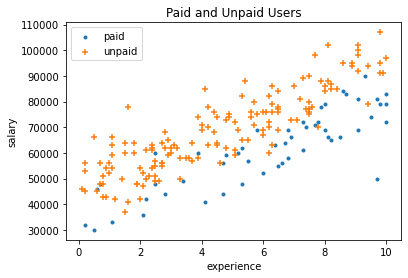

In [10]:
plt.scatter([row[0] for row in data if row[2]],
            [row[1] for row in data if row[2]],
            marker='.', label='paid')
plt.scatter([row[0] for row in data if not row[2]],
            [row[1] for row in data if not row[2]],
            marker='+', label='unpaid')
plt.xlabel('experience')
plt.ylabel('salary')
plt.legend()
plt.title('Paid and Unpaid Users')
plt.show()

$ paid account = \beta_0 + \beta_1 experience + \beta_2 salary + ε $

In [11]:
rescaled_x = rescale(x)
# beta = estimate_beta(rescaled_x, y) # [0.26, 0.43, -0.43]
beta = least_squares_fit(rescaled_x, y) # [0.26, 0.43, -0.43]
predictions = [predict(x_i, beta) for x_i in rescaled_x]

least squares fit: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 472.73it/s]


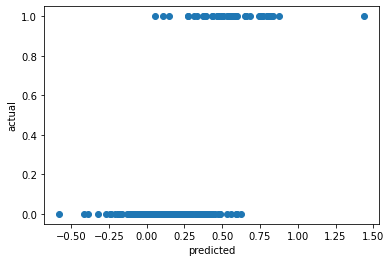

In [12]:
plt.scatter(predictions, y)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

## The Logistic Function

In [13]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

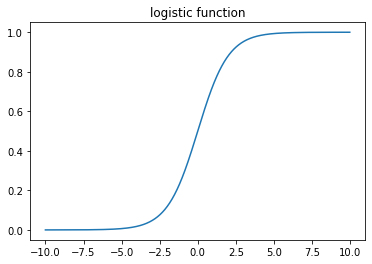

In [14]:
z = [zi/50 - 10 for zi in range(1000)]
plt.plot(z, [logistic(zi) for zi in z])
plt.title('logistic function')
plt.show()

In [15]:
def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i==1:
        return math.log(logistic(dot(x_i, beta)))
    else:
        return math.log(1 - logistic(dot(x_i, beta)))

In [16]:
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta)
        for x_i, y_i in zip(x, y))

In [17]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """here i is the index of the data point, j the index of the derivative"""
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

In [18]:
def logistic_log_gradient_i(x_i, y_i, beta):
    """the gradient of the log likelihood corresponding to the ith data point"""
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j, _ in enumerate(beta)]

In [19]:
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add,
        [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x,y)])

In [20]:
random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# want to maximize log likelihood on the training data
fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# pick a random starting point
beta_0 = [random.random() for _ in range(3)] # and maximize using gradient descent
beta_hat, training_errs = maximize_batch(fn, gradient_fn, beta_0)

In [37]:
beta_hat


list

In [22]:
beta_hat,cnt = maximize_stochastic2(logistic_log_likelihood_i,
                               logistic_log_gradient_i,
                               x_train, y_train, beta_0,tolerance=0.000001)

In [23]:
cnt

5

In [24]:
beta_hat

[-2.0128471167441115, 4.657282171733147, -4.434962888435817]

## Goodness of Fit

In [25]:
true_positives = false_positives = true_negatives = false_negatives = 0
for x_i, y_i in zip(x_test, y_test):
    predict = logistic(dot(beta_hat, x_i))

    # TP: paid and we predict paid
    if y_i == 1 and predict >= 0.5:
        true_positives += 1

    # FN: paid and we predict unpaid
    elif y_i == 1:
        false_negatives += 1

    # FP: unpaid and we predict paid
    elif predict >= 0.5:
        false_positives += 1

    # TN: unpaid and we predict unpaid
    else:
        true_negatives += 1

In [26]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
precision, recall

(0.75, 0.8)

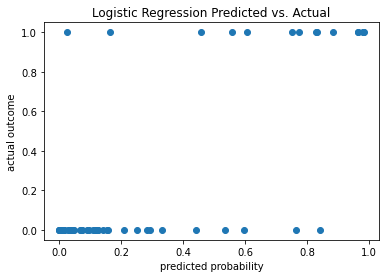

In [27]:
predictions = [logistic(dot(beta_hat, x_i)) for x_i in x_test]
plt.scatter(predictions, y_test)
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()

## The Decision Boundary

### Unscaling the coefficients

First we need to unscale the coefficients. The book gives them, but let's figure out how those are computed.

In [28]:
beta_hat_unscaled = [7.61, 1.42, -0.000249]

$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $

$ y = \beta_0 + \beta_1 (xus_1 - \mu_1)/\sigma_1  + \beta_2 (xus_2 - \mu_2)/\sigma_2 $

$ y = (\beta_0 - \beta_1\mu_1/\sigma_1 - \beta_2\mu_2/\sigma_2) + \beta_1/\sigma_1 xus_1  + \beta_2/\sigma_2 xus_2 $


In [29]:
beta_hat

[-2.0128471167441115, 4.657282171733147, -4.434962888435817]

In [30]:
mu_1 = mean([xi[1] for xi in x])
sig_1 = standard_deviation([xi[1] for xi in x])

mu_2 = mean([xi[2] for xi in x])
sig_2 = standard_deviation([xi[2] for xi in x])

In [31]:
beta_hat_unscaled[0] = beta_hat[0] - (beta_hat[1]*mu_1)/sig_1 - (beta_hat[2]*mu_2)/sig_2
beta_hat_unscaled[0]

8.851468651395924

In [32]:
beta_hat_unscaled[1] = beta_hat[1]/sig_1
beta_hat_unscaled[1]

1.63564168800389

In [33]:
beta_hat_unscaled[2] = beta_hat[2]/sig_2
beta_hat_unscaled[2]

-0.00028544607083633394

### Compute the decision boundary

The decision boundary is where the dot product of $\beta$ and _x_ is zero.

$ \beta \cdot x = 0 $

$ \beta_1 x_1 + \beta_2 x_2 = -\beta_0 $

...or the line defined by:

$ x_2 = - \beta_1/\beta_2 x_2 - \beta_0/\beta_2 $

In [34]:
x_db = [xi/2 for xi in range(21)]
y_db = [(-beta_hat_unscaled[1]/beta_hat_unscaled[2]*xi - beta_hat_unscaled[0]/beta_hat_unscaled[2])
        for xi in x_db]

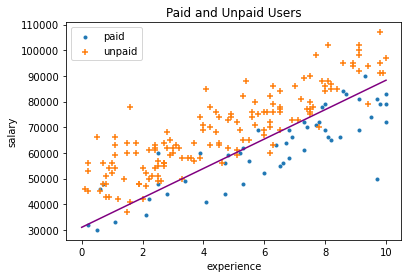

In [35]:
plt.scatter([row[0] for row in data if row[2]],
            [row[1] for row in data if row[2]],
            marker='.', label='paid')
plt.scatter([row[0] for row in data if not row[2]],
            [row[1] for row in data if not row[2]],
            marker='+', label='unpaid')
plt.plot(x_db, y_db, 'purple')
plt.xlabel('experience')
plt.ylabel('salary')
plt.legend()
plt.title('Paid and Unpaid Users')
plt.show()